# Exercise 2: Word polarity detection with word embedding

a) Read lexicons. Download lists of positive and negative words from the Opinion Lexicon available from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html. A zip
is also provided on Moodle. Listing 1 provides an example of function to read the lexicons. You may want to complete the code to remove lines that start with ;, that end with + and to remove empty lines. You should get 2005 positive words and 4783 negative words.

In [216]:
def read_vocabulary_from_file(filename):
    with open(filename , "r", encoding="ISO−8859−1") as f:
        content = f.readlines() # content is a list of lines
        content = [x.strip() for x in content] # removing newline chars
        content = [c for c in content if not c.startswith(";")]
        content = [c for c in content if not c.endswith("+")]
        content = [c for c in content if not c == ""]
        return content
    
positive_words = read_vocabulary_from_file("opinion-lexicon-English/positive-words.txt")
negative_words = read_vocabulary_from_file("opinion-lexicon-English/negative-words.txt")
print("Positive words:", len(positive_words))
print("Negative words:", len(negative_words))

Positive words: 2005
Negative words: 4783


b) Convert words into vectors. You can here go for two options : either by querying an online API that returns you the vectors for a given word, or download a pre-trained 3 word-vector dictionary (word2vec, GloVe, etc.). The code provided in Listing 2 shows you how to realise this using a GloVe embedding – zip also provided on Moodle.

In [217]:
# online query
import requests
import json
import numpy as np

# THIS WORKS BUT NOT WITH THOUSAND OF REQUESTS IN SHORT TIME (PROBABLY SERVER BLOCKS IT AT SOME POINT)
# https://icoservices.kube.isc.heia-fr.ch/word-embedding/showcase
# def get_word2vec_vector(word):
#     with requests.get("https://icoservices.kube.isc.heia-fr.ch/word-embedding/wordvector/word2vec/en/" + word) as response:
#         vector = response.json()
#     return vector

def load_glove_embeddings(path):
    embeddings = {}
    with open(path , "r", encoding="utf−8") as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype="float32")
            embeddings[w] = vectors
    return embeddings

def get_glove_vector(word, word_dict):
    try:
        return np.array(word_dict[word])
    except KeyError:
        print(f"Word '{word}' not found in the GloVe embeddings.")
        return np.zeros(50)

word_dict = load_glove_embeddings("glove.6B.50d.txt")
positive_words_vectors = np.array([get_glove_vector(word, word_dict) for word in positive_words])
negative_words_vectors = np.array([get_glove_vector(word, word_dict) for word in negative_words])
print("Positive words vector:", positive_words_vectors.shape)
print("Negative words vector:", negative_words_vectors.shape)

Word 'accessable' not found in the GloVe embeddings.
Word 'achievible' not found in the GloVe embeddings.
Word 'adorer' not found in the GloVe embeddings.
Word 'adulate' not found in the GloVe embeddings.
Word 'afordable' not found in the GloVe embeddings.
Word 'agilely' not found in the GloVe embeddings.
Word 'amiabily' not found in the GloVe embeddings.
Word 'awsome' not found in the GloVe embeddings.
Word 'beautifullly' not found in the GloVe embeddings.
Word 'believeable' not found in the GloVe embeddings.
Word 'benifits' not found in the GloVe embeddings.
Word 'better-than-expected' not found in the GloVe embeddings.
Word 'beutifully' not found in the GloVe embeddings.
Word 'brilliances' not found in the GloVe embeddings.
Word 'cashbacks' not found in the GloVe embeddings.
Word 'contrasty' not found in the GloVe embeddings.
Word 'convience' not found in the GloVe embeddings.
Word 'convienient' not found in the GloVe embeddings.
Word 'convient' not found in the GloVe embeddings.
Wo

c) Prepare the training and testing sets. Prepare the tensors X_train for training by taking the corresponding vectors of 1500 positive and 1500 negative words from the
lexicon. Prepare the Y_train target output tensor corresponding to the training set. You can, for example use the target [1.0, 0.0] for a positive word and [0.0, 1.0] for a negative word. For an embedding dimension of 50, the shapes of your X_train and Y_train tensors should be (3000,50) and (3000,2). In a similar way, prepare X_test and Y_test tensors.

In [218]:
import pandas as pd
# Construct everything together to a dataframe
data_pos = zip(positive_words, positive_words_vectors, "+"*len(positive_words))
data_neg = zip(negative_words, negative_words_vectors, "-"*len(negative_words))

# Create the pandas DataFrame
df_pos = pd.DataFrame(data_pos, columns=['Word', 'WordVector', "Sentiment"])
df_neg = pd.DataFrame(data_neg, columns=['Word', 'WordVector', "Sentiment"])
# print(df_pos.info())
# print(df_neg.info())

# Train Set
# Y_train
N = 1500
Y_train = np.zeros(shape=(N*2, 2))
Y_train[0:N-1] = np.array([1., 0])
Y_train[N:] = np.array([0, 1.])
# X_train
X_train_pos = np.array(df_pos.sample(n=N)["WordVector"].tolist())
X_train_neg = np.array(df_neg.sample(n=N)["WordVector"].tolist())
X_train = np.concatenate((X_train_pos, X_train_neg))

# Negative samples
#X_train = np.append(X_train, negative_words_vectors[test_idx_negative])

print(X_train.shape)
print(Y_train.shape)

# print(X_train[0])
# print(Y_train[0])

# Test set
N = 400
Y_test = np.zeros(shape=(N*2, 2))
Y_test[0:N-1] = np.array([1., 0])
Y_test[N:] = np.array([0, 1.])
X_test_pos = np.array(df_pos.sample(n=N)["WordVector"].tolist())
X_test_neg = np.array(df_neg.sample(n=N)["WordVector"].tolist())
X_test = np.concatenate((X_test_pos, X_test_neg))
print(X_test.shape)
print(Y_test.shape)

(3000, 50)
(3000, 2)
(800, 50)
(800, 2)


d) Train and evaluate a classifier. Build a model, e.g. a double Dense layers in Keras (MLP) and train it. Report on the evolution of the loss and accuracy along the epochs. You should reach about 90% accuracy on the training set and 85% accuracy on the test set. Report on your model structure and fitting strategy.

In [219]:
from tensorflow import keras

n_classes = 2
n_units = 256

# Define model
model = keras.models.Sequential()
model.add(keras.Input(shape=(X_train.shape[1])))
model.add(keras.layers.Dense(units=n_units))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(units=n_units))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(units=n_classes))
model.add(keras.layers.Activation("softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               13056     
                                                                 
 activation_13 (Activation)  (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 activation_14 (Activation)  (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                                 
 activation_15 (Activation)  (None, 2)                 0         
                                                                 
Total params: 79,362
Trainable params: 79,362
Non-trai

Epoch 1/10
94/94 [==============================] - 1s 8ms/step - loss: 0.4002 - accuracy: 0.8137 - val_loss: 0.3233 - val_accuracy: 0.8537
Epoch 2/10
94/94 [==============================] - 1s 7ms/step - loss: 0.3252 - accuracy: 0.8563 - val_loss: 0.3034 - val_accuracy: 0.8637
Epoch 3/10
94/94 [==============================] - 1s 7ms/step - loss: 0.2878 - accuracy: 0.8757 - val_loss: 0.2832 - val_accuracy: 0.8637
Epoch 4/10
94/94 [==============================] - 1s 6ms/step - loss: 0.2589 - accuracy: 0.8857 - val_loss: 0.2588 - val_accuracy: 0.8925
Epoch 5/10
94/94 [==============================] - 1s 9ms/step - loss: 0.2205 - accuracy: 0.9030 - val_loss: 0.2465 - val_accuracy: 0.8938
Epoch 6/10
94/94 [==============================] - 1s 8ms/step - loss: 0.1971 - accuracy: 0.9130 - val_loss: 0.2511 - val_accuracy: 0.9000
Epoch 7/10
94/94 [==============================] - 1s 9ms/step - loss: 0.1675 - accuracy: 0.9307 - val_loss: 0.2408 - val_accuracy: 0.9112
Epoch 8/10
94/94 [==

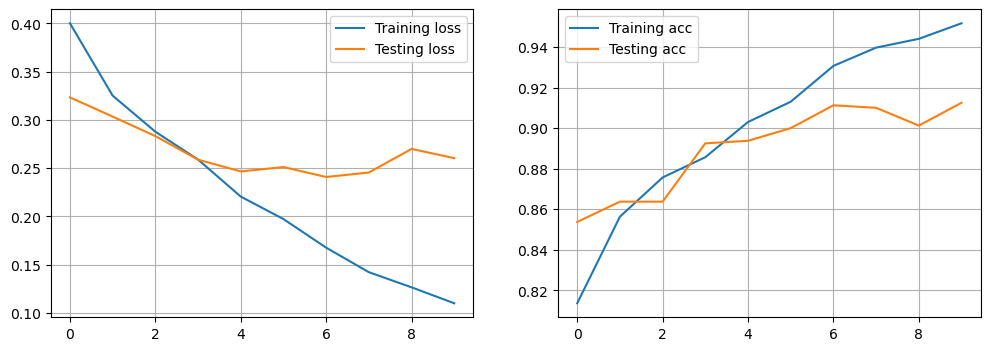

In [220]:
import matplotlib.pyplot as plt

batch_size = 32
n_epochs = 10

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"]
             )

log = model.fit(x=X_train,
          y=Y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          validation_data=(X_test, Y_test),
         )

f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

I chose a relatively simple model, two hidden layers with 256 units. Validation accuracy of around 0.9 is pretty good I guess.

e) Analysis of results and discussions. Report on your experiments and comment your classification performances. Find 5 to 10 words which are not in your training set and on which the system thinks it is clearly positive or negative. Find some words on which the system hesitates, i.e. with output probabilities in range [0.4-0.6]). Are these words and outputs making sense to you ?

In [221]:
def get_prob(word, sentiment):
    if sentiment == "positive":
        df = df_pos
    else:
        df = df_neg
    word_vector = np.array(df[df["Word"] == word]["WordVector"].tolist())
    y_pred = model.predict(x=word_vector)
    return np.round(y_pred, 4)
    
unseen_words = []
sentiments = []
for idx, row in df_pos.iterrows():
    if not row["WordVector"] in X_train_pos:
        unseen_words.append(row['Word'])
        sentiments.append("positive")
for idx, row in df_neg.iterrows():
    if not row["WordVector"] in X_train_pos:
        unseen_words.append(row['Word'])
        sentiments.append("negative")

for word, sentiment in zip(unseen_words, sentiments):
    # Dont' do it with all words but just some words at random
    if np.random.randint(0, 25) == 0:
        print(f"Probabilities for word {word}:", get_prob(word, sentiment))


Probabilities for word admiration: [[1. 0.]]
Probabilities for word bravo: [[0.8452 0.1548]]
Probabilities for word congenial: [[9.996e-01 4.000e-04]]
Probabilities for word divinely: [[1. 0.]]
Probabilities for word lively: [[1. 0.]]
Probabilities for word low-priced: [[0.9948 0.0052]]
Probabilities for word privilege: [[9.997e-01 3.000e-04]]
Probabilities for word salutary: [[0.455 0.545]]
Probabilities for word thoughtfulness: [[0.9953 0.0047]]
Probabilities for word well-established: [[0.6934 0.3066]]
Probabilities for word abnormal: [[0.4775 0.5225]]
Probabilities for word accusations: [[0. 1.]]
Probabilities for word aggrieved: [[0. 1.]]
Probabilities for word amputate: [[0.8395 0.1605]]
Probabilities for word apathetic: [[0. 1.]]
Probabilities for word ashamed: [[0.0182 0.9818]]
Probabilities for word atrocious: [[3.000e-04 9.997e-01]]
Probabilities for word barbarous: [[0.0042 0.9958]]
Probabilities for word belligerent: [[0.0011 0.9989]]
Probabilities for word bland: [[0.0384 

For the following words the model has a very clear idea if its positive or negative:  
scandalous: [[0. 1.]]  
treason: [[0. 1.]]    
cynical: [[0. 1.]]  
cost-saving: [[0.9957 0.0043]]   
exceptionally: [[9.998e-01 2.000e-04]]   

For the following words the model hesitates and is unsure:  
rollercoaster: [[0.4304 0.5696]]  
redundant: [[0.5185 0.4815]]   
improbably: [[0.6268 0.3732]]  
rough: [[0.4539 0.5461]]  

Overall the outputs make a lot of sense. Also not being able to classify certain words is "normal" as it depends a lot on which context they are being used. 